# [1]. Reading Data

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the CSV dataset <br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
import seaborn as sn
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Adarsh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#loading train and test and validation dataset

file=open("x_train.pkl","rb")
x_train=pickle.load(file) # loading 'train' dataset

file=open("x_cv.pkl",'rb')
x_cv=pickle.load(file) # loading 'validation' dataset

file=open("x_test.pkl",'rb')
x_test=pickle.load(file) # loading 'test' dataset

file=open("y_train.pkl","rb")
y_train=pickle.load(file) # loading 'train' dataset

file=open("y_cv.pkl",'rb')
y_cv=pickle.load(file) # loading 'validation' dataset

file=open("y_test.pkl",'rb')
y_test=pickle.load(file) # loading 'test' dataset

#loading train_bow and test _bow
file=open('x_train_bow.pkl','rb')
x_train_bow=pickle.load(file)

file=open('x_test_bow.pkl','rb')
x_test_bow=pickle.load(file)

file=open('x_cv_bow.pkl','rb')
x_cv_bow=pickle.load(file)

#loading train_tf_idf and test_tf_idf
file=open('train_tf_idf.pkl','rb')
train_tf_idf=pickle.load(file)

file=open('cv_tf_idf.pkl','rb')
cv_tf_idf=pickle.load(file)

file=open('test_tf_idf.pkl','rb')
test_tf_idf=pickle.load(file)

#loading train_w2v and test_w2v
file=open('train_w2v.pkl','rb')
train_w2v=pickle.load(file)

file=open('cv_w2v.pkl','rb')
cv_w2v=pickle.load(file)

file=open('test_w2v.pkl','rb')
test_w2v=pickle.load(file)

#loading train_tf_idf_w2v and test_tf_idf_w2v
file=open('train_tf_idf_w2v.pkl','rb')
train_tf_idf_w2v=pickle.load(file)

file=open('cv_tf_idf_w2v.pkl','rb')
cv_tf_idf_w2v=pickle.load(file)

file=open('test_tf_idf_w2v.pkl','rb')
test_tf_idf_w2v=pickle.load(file)

In [7]:
# using csv Table to read data.

dataset=pd.read_csv("Reviews.csv") 

print(dataset.shape)
dataset.head(3)



(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# taking reviews whose score is not equal to 3
filtered_dataset=dataset[dataset['Score']!=3]
filtered_dataset.shape

#creating a function to filter the reviews (if score>3 --> positive , if score<3 --> negative)
def partition(x):
    if x>3:
        return 1
    return 0

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_dataset['Score']
positiveNegative = actualScore.map(partition) 
filtered_dataset['Score'] = positiveNegative
print("Number of data points in our data", filtered_dataset.shape)
filtered_dataset.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

#### observation:
As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
# sorting the value
sorted_data=filtered_dataset.sort_values(by='Id',inplace=True )
#finding the dublicate values using 'df.dublicated'
filtered_dataset[filtered_dataset.duplicated(subset={'ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'})].shape
#alternate way to drop dublicate values
dataset_no_dup=filtered_dataset.drop_duplicates(subset={'ProfileName','Score','Time','Summary'},keep='first')
print(f"before {dataset.shape}")
print(f"after removing duplicate values-->shape = {dataset_no_dup.shape}")
# %age of no. of review reamin in data set
print('percentage of data reamin after removing duplicate values and removing reviews with neutral scores % .2f'
      %((dataset_no_dup.size/dataset.size)*100))



before (568454, 10)
after removing duplicate values-->shape = (363255, 10)
percentage of data reamin after removing duplicate values and removing reviews with neutral scores  63.90


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
# removing reviews where "HelpfulnessNumerator>HelpfulnessDenominator"
final=dataset_no_dup[dataset_no_dup['HelpfulnessNumerator']<=dataset_no_dup['HelpfulnessDenominator']]


In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(363253, 10)


1    306222
0     57031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [9]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 363253/363253 [02:56<00:00, 2063.41it/s]


In [10]:
preprocessed_reviews[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
final['preprocessed_reviews']=preprocessed_reviews

In [12]:
# splitting the dataset in train , cv and test 

n=final.shape[0] #size of final dataset

train=final.iloc[:round(0.60*n),:]
cv=final.iloc[round(0.60*n):round(0.80*n),:]
test=final.iloc[round(0.80*n):round(1.0*n),:]

In [13]:
from sklearn.model_selection import train_test_split
x_training,x_test,y_training,y_test=train_test_split(preprocessed_reviews,final["Score"] ,test_size=0.20, random_state=42)
x_train,x_cv,y_train,y_cv=train_test_split(x_training,y_training, test_size=0.25, random_state=42)

In [48]:
len(x_train),len(y_train),len(x_test),len(y_test),len(x_cv),len(y_cv)

(217951, 217951, 72651, 72651, 72651, 72651)

In [14]:
# saving train and test dataset using pickle for fututre use

'''file=open("x_train.pkl","wb")
pickle.dump(x_train,file)
file.close()

file=open('x_cv.pkl','wb')
pickle.dump(x_cv,file)
file.close

file=open("x_test.pkl",'wb')
pickle.dump(x_test,file)
file.close()


file=open("y_train.pkl","wb")
pickle.dump(y_train,file)
file.close()

file=open('y_cv.pkl','wb')
pickle.dump(y_cv,file)
file.close

file=open("y_test.pkl",'wb')
pickle.dump(y_test,file)
file.close()

'''

In [2]:
#loading train and test and validation dataset

file=open("x_train.pkl","rb")
x_train=pickle.load(file) # loading 'train' dataset

file=open("x_cv.pkl",'rb')
x_cv=pickle.load(file) # loading 'validation' dataset

file=open("x_test.pkl",'rb')
x_test=pickle.load(file) # loading 'test' dataset

file=open("y_train.pkl","rb")
y_train=pickle.load(file) # loading 'train' dataset

file=open("y_cv.pkl",'rb')
y_cv=pickle.load(file) # loading 'validation' dataset

file=open("y_test.pkl",'rb')
y_test=pickle.load(file) # loading 'test' dataset


# [4] Featurization

## [4.1] BAG OF WORDS

In [20]:
#BoW

count_vect = CountVectorizer()#in scikit-learn

x_train_bow=count_vect.fit_transform(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*100)

# transform cv and test dataset
x_cv_bow=count_vect.transform(x_cv)
x_test_bow=count_vect.transform(x_test)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa']


In [15]:
x_train_bow.shape,x_test_bow.shape,x_cv_bow.shape


((217951, 90000), (72651, 90000), (72651, 90000))

In [17]:
# saving train_bow and test_bow dataset using pickle for future use

'''file=open("x_train_bow.pkl","wb")
pickle.dump(x_train_bow,file)
file.close()

file=open("x_test_bow.pkl",'wb')
pickle.dump(x_test_bow,file)
file.close()

file=open("x_cv_bow.pkl",'wb')
pickle.dump(x_cv_bow,file)
file.close()
'''

In [15]:
#loading train_bow and test _bow
file=open('x_train_bow.pkl','rb')
x_train_bow=pickle.load(file)

file=open('x_test_bow.pkl','rb')
x_test_bow=pickle.load(file)

file=open('x_cv_bow.pkl','rb')
x_cv_bow=pickle.load(file)

## [4.3] TF-IDF

In [68]:
# tf-idf "from sklearn.feature_extraction.text.TfidfVectorizer"
tf_idf=TfidfVectorizer()

train_tf_idf=tf_idf.fit_transform(x_train)
cv_tf_idf=tf_idf.transform(x_cv)
test_tf_idf=tf_idf.transform(x_test)

In [71]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler(with_mean=False)

train_tf_idf=sc.fit_transform(train_tf_idf)
cv_tf_idf=sc.transform(cv_tf_idf)
test_tf_idf=sc.transform(test_tf_idf)

In [21]:
# saving train_tf_idf and test_tf_idf dataset using pickle for fututre use

'''file=open("train_tf_idf.pkl","wb")
pickle.dump(train_tf_idf,file)
file.close()

file=open("cv_tf_idf.pkl",'wb')
pickle.dump(cv_tf_idf,file)
file.close()

file=open("test_tf_idf.pkl",'wb')
pickle.dump(test_tf_idf,file)
file.close()

'''


In [4]:
#loading train_tf_idf and test_tf_idf
file=open('train_tf_idf.pkl','rb')
train_tf_idf=pickle.load(file)

file=open('cv_tf_idf.pkl','rb')
cv_tf_idf=pickle.load(file)

file=open('test_tf_idf.pkl','rb')
test_tf_idf=pickle.load(file)

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# converting our text-->vector using w2v with 50-dim
# more the dimension of each word = better the semantic of word
# using lib from "gensim.models.Word2Vec"
# to run w2v we need list of list of the words as w2v covert each world into number of dim


# for train_w2v
list_of_sent_train=[]
for sent in x_train:
    list_of_sent_train.append((str(sent)).split())
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50)

# vocablary of w2v model of amazon dataset
vocab=w2v_model.wv.vocab
len(vocab)

#-------------------------------------------------------------------------------------------------

# for test_w2v
list_of_sent_cv=[]
for sent in x_cv:
    list_of_sent_cv.append((str(sent)).split())

#-------------------------------------------------------------------------------------------------

# for test_w2v
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append((str(sent)).split())


C:\Users\Adarsh\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [7]:
'''
    -->procedure to make avg w2v of each reviews
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# average Word2Vec
# compute average word2vec for each review.
train_w2v = []; # the avg-w2v for each sentence/review in train dataset is stored in this list

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)

print(len(train_w2v))

#-----------------------------------------------------------------------------------

cv_w2v = []; # the avg-w2v for each sentence/review in test dataset is stored in this list

for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)

print(len(cv_w2v))


#-----------------------------------------------------------------------------------

test_w2v = []; # the avg-w2v for each sentence/review in test dataset is stored in this list

for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)

print(len(test_w2v))

217951
72651
72651


In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=True)

train_w2v=sc.fit_transform(train_w2v)
cv_w2v=sc.transform(cv_w2v)
test_w2v=sc.transform(test_w2v)

In [10]:
# saving train_w2v and test_w2v dataset using pickle for fututre use

'''file=open("train_w2v.pkl","wb")
pickle.dump(train_w2v,file)
file.close()

file=open("cv_w2v.pkl",'wb')
pickle.dump(cv_w2v,file)
file.close()

file=open("test_w2v.pkl",'wb')
pickle.dump(test_w2v,file)
file.close()
'''


In [5]:
#loading train_w2v and test_w2v
file=open('train_w2v.pkl','rb')
train_w2v=pickle.load(file)

file=open('cv_w2v.pkl','rb')
cv_w2v=pickle.load(file)

file=open('test_w2v.pkl','rb')
test_w2v=pickle.load(file)

In [21]:
train_w2v[0]

array([-0.0080363 , -0.55650226, -2.24174777,  1.02574886,  0.12327979,
       -0.19916425, -1.06522974,  0.89144715, -1.13231167,  2.54008377,
        0.8032532 ,  0.3404576 ,  1.6792167 , -0.98081078,  1.08851643,
       -0.72007858, -0.65714762, -0.56007184,  0.01985994,  2.12137305,
       -0.09203752, -0.23671867, -1.63326771,  1.04496922,  0.45004579,
        0.3219116 ,  0.78335079,  0.54301334, -2.4968575 ,  0.35478244,
        1.46397278, -0.01982212, -0.1817636 ,  1.35729521, -0.61338792,
       -1.68822842, -0.84256537, -0.59978494,  0.40587478, -0.49775708,
        0.31289323,  0.34938107, -0.18756661, -2.25982333,  0.01440547,
       -0.97699964, -0.10107761,  0.28043456,  1.88480264, -0.81507891])

In [12]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  26749
sample words  ['really', 'nice', 'seasoning', 'bought', 'product', 'sam', 'club', 'happy', 'able', 'purchase', 'cannot', 'get', 'anymore', 'use', 'meats', 'spaghetti', 'coffee', 'not', 'bad', 'defiantly', 'anything', 'special', 'price', 'could', 'ethical', 'fair', 'trade', 'organic', 'shade', 'grown', 'etc', 'taste', 'ok', 'stick', 'dean', 'beans', 'smooth', 'flavorful', 'medium', 'roast', 'pleasantly', 'surprised', 'k', 'cup', 'would', 'deal', 'drew', 'glad', 'dogs', 'love']


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec Train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tf_idf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

#list_of_sentence_train=list_of_sent_train[:30000] # reducing the size of train list due to computational constrain

for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tf_idf_w2v.append(sent_vec)
    row += 1
    
len(train_tf_idf_w2v)

In [15]:
# TF-IDF weighted Word2Vec cv
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tf_idf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

#list_of_sentence_train=list_of_sent_train[:30000] # reducing the size of train list due to computational constrain

for sent in tqdm(list_of_sent_cv[:20000]): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tf_idf_w2v.append(sent_vec)
    row += 1
    
len(cv_tf_idf_w2v)

100%|██████████| 20000/20000 [17:19<00:00, 19.23it/s]


20000

In [16]:
# TF-IDF weighted Word2Vec Test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tf_idf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

#list_of_sentence_train=list_of_sent_train[:30000] # reducing the size of train list due to computational constrain

for sent in tqdm(list_of_sent_test[:20000]): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tf_idf_w2v.append(sent_vec)
    row += 1
    
len(test_tf_idf_w2v)

100%|██████████| 20000/20000 [17:31<00:00, 19.03it/s]


20000

In [15]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=True)

train_tf_idf_w2v=sc.fit_transform(train_tf_idf_w2v)
cv_tf_idf_w2v=sc.transform(cv_tf_idf_w2v)
test_tf_idf_w2v=sc.transform(test_tf_idf_w2v)

In [16]:
# saving train_tf_idf_w2v and test_tf_idf_w2v dataset using pickle for fututre use

'''file=open("train_tf_idf_w2v.pkl","wb")
pickle.dump(train_tf_idf_w2v,file)
file.close()

file=open("cv_tf_idf_w2v.pkl",'wb')
pickle.dump(cv_tf_idf_w2v,file)
file.close()

file=open("test_tf_idf_w2v.pkl",'wb')
pickle.dump(test_tf_idf_w2v,file)
file.close()

'''


In [6]:
#loading train_tf_idf_w2v and test_tf_idf_w2v
file=open('train_tf_idf_w2v.pkl','rb')
train_tf_idf_w2v=pickle.load(file)

file=open('cv_tf_idf_w2v.pkl','rb')
cv_tf_idf_w2v=pickle.load(file)

file=open('test_tf_idf_w2v.pkl','rb')
test_tf_idf_w2v=pickle.load(file)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

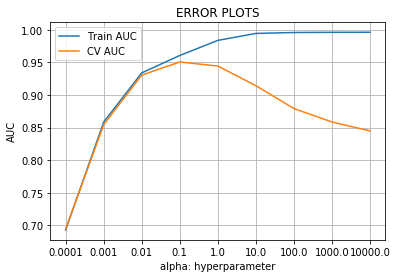

In [4]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l1', C=i,class_weight='balanced')
    clf.fit(x_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, x_train_bow.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train_bow[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, x_cv_bow.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv_bow[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.1 is 0.95

misclassification percentage is 0.11%


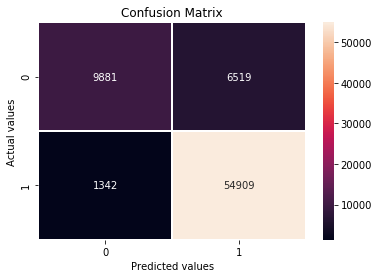



classification report:
              precision    recall  f1-score   support

          0       0.60      0.88      0.72     11223
          1       0.98      0.89      0.93     61428

avg / total       0.92      0.89      0.90     72651



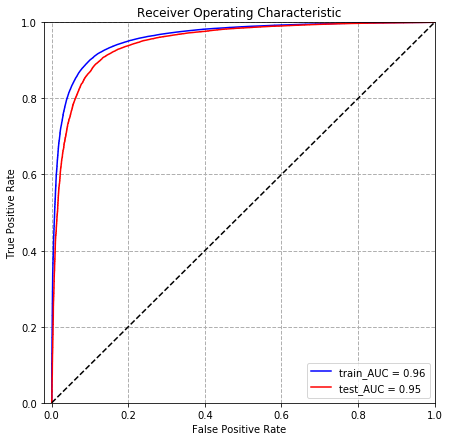

In [55]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.1 #optimum 'alpha'

clf=LogisticRegression(penalty='l1', C=optimum_c,class_weight='balanced')
clf.fit(x_train_bow,y_train)


y_pred = []
for i in range(0, x_test_bow.shape[0], 1000):
    y_pred.extend(clf.predict(x_test_bow[i:i+1000]))
    
y_pred_proba = []
for i in range(0, x_test_bow.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(x_test_bow[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, x_train_bow.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(x_train_bow[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

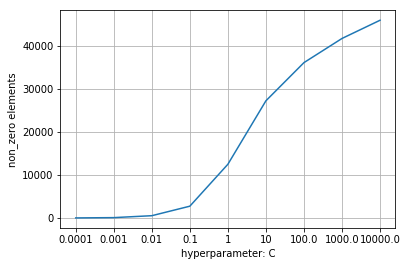

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]

non_zero=[]

for i in c_range:
    clf=LogisticRegression(penalty='l1', C=i,class_weight='balanced')
    clf.fit(x_train_bow,y_train)
    non_zero.append(np.count_nonzero(clf.coef_))
    
plt.plot(np.arange(9),non_zero)
plt.xlabel('hyperparameter: C')
plt.xticks(np.arange(9),c_range)
plt.ylabel('non_zero elements')
plt.grid()
plt.show()

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

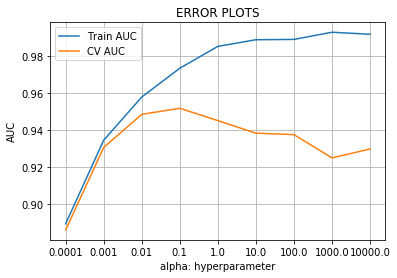

In [45]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(x_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, x_train_bow.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(x_train_bow[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, x_cv_bow.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(x_cv_bow[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.1 is 0.95

misclassification percentage is 0.10%


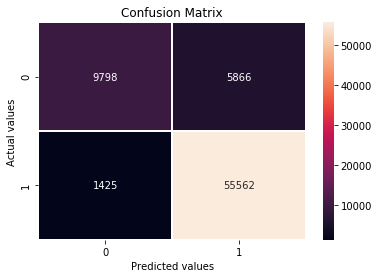



classification report:
              precision    recall  f1-score   support

          0       0.63      0.87      0.73     11223
          1       0.97      0.90      0.94     61428

avg / total       0.92      0.90      0.91     72651



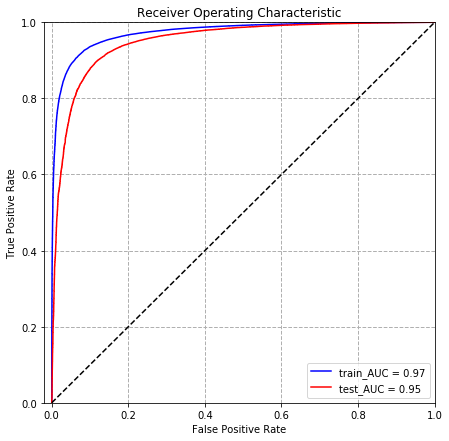

In [46]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c= 0.1 #optimum 'alpha'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(x_train_bow,y_train)


y_pred = []
for i in range(0, x_test_bow.shape[0], 1000):
    y_pred.extend(clf.predict(x_test_bow[i:i+1000]))
    
y_pred_proba = []
for i in range(0, x_test_bow.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(x_test_bow[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, x_train_bow.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(x_train_bow[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [8]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm

optimum_c= 0.1 #optimum 'C=1/lambda'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(x_train_bow,y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
# weights before adding noise
w1=clf.coef_

e=norm.rvs(loc=0,scale=0.1) #small random noise
print("adding small noise e =",e)

#adding small noise e to x_train_bow
x_train_bow_dash=x_train_bow
x_train_bow_dash.data=x_train_bow_dash.data+e

adding small noise e = 0.06312433357191576


In [10]:
#Traning after adding small noise

optimum_c= 0.1 #optimum 'C=1/lambda0'

clf1=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf1.fit(x_train_bow_dash,y_train)

#weights after adding noise and fitting
w2=clf1.coef_

#adding small epsilon=10e-6 into weights to neglect divide by zero error
w1=w1+10e-6 
w2=w2+10e-6 

#difference in weights before adding noise and weights after adding noise w.r.t weights bfore adding noise
diff=(np.absolute((w1-w2)/w1))*100  

In [11]:
# 0th,10th, 20th, ........,100th percentile of difference in weights

pd.DataFrame({"percentile":np.arange(0,101,10),"diffenece in weights":np.percentile(diff, np.arange(0,101,10))})


,percentile,diffenece in weights
0,0,0.000095
1,10,0.648600
2,20,1.441971
3,30,2.244430
4,40,3.092366
5,50,3.994646
6,60,4.920422
7,70,5.996831
8,80,7.354784
9,90,10.714592


##### observation
1.There is a sudden change weights from 90th percentle to 100th percentile

2.Observe the values from 90th percentile to 100th percentile

In [12]:
# 90th,91th,92th, ........,100th percentile of difference in weights
pd.DataFrame({"percentile":np.arange(90,101,1),"diffenece in weights":np.percentile(diff, np.arange(90,101,1))})


,percentile,diffenece in weights
0,90,10.714592
1,91,11.339809
2,92,12.120393
3,93,13.000132
4,94,14.174486
5,95,15.857957
6,96,18.102958
7,97,21.384177
8,98,28.486196
9,99,51.563896


In [13]:
# 99th,99.1th,99.2th, ........,100th percentile of difference in weights
pd.DataFrame({"percentile":np.arange(99,100.1,0.1),"diffenece in weights":np.percentile(diff, np.arange(99,100.1,0.1))})



,percentile,diffenece in weights
0,99.0,51.563896
1,99.1,56.825445
2,99.2,62.553310
3,99.3,69.496556
4,99.4,81.677091
5,99.5,96.272264
6,99.6,114.715569
7,99.7,153.678480
8,99.8,231.015229
9,99.9,457.995613


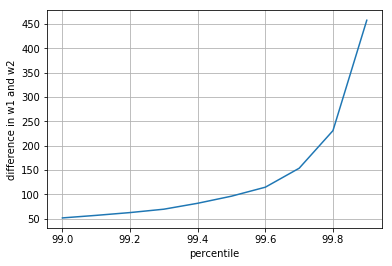

In [15]:
plt.plot(np.arange(99,100,0.1),np.percentile(diff, np.arange(99,100,0.1)))
plt.xlabel("percentile")
plt.ylabel("difference in w1 and w2")
plt.grid()
plt.show()

#### Observation:
Above plot indicating threashold value at 114.7 or 99.6 percentile i.e 0.4 percentile have weight difference more than 114.7 or considerd to be multicollinear

In [17]:
#Q how many feature is multicollinear
print("Number of features which are multicollinear =",len(diff[diff>114.7]))

Number of features which are multicollinear = 361


In [21]:
multicollinear_features=pd.DataFrame({"features":count_vect.get_feature_names(),"diff in weights":diff[0]})

#### top 10 multicolliner features

In [22]:
#top 10 multicolliner features
multicollinear_features.sort_values(by="diff in weights")[:-10:-1]

,features,diff in weights
17629,coonhound,6559.855704
10283,buch,5520.634962
11429,campbells,4636.986778
21396,dessicate,4289.344986
62932,purelo,4289.344986
20980,demons,4222.485705
75860,struvite,4061.973298
61419,preservaties,3703.797331
52640,neumans,3401.382803


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [47]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm

optimum_c= 0.1 #optimum 'C=1/lambda'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(x_train_bow,y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [48]:
feature_name=count_vect.get_feature_names() #using count_vectoriser to get features names
coef=clf.coef_ # storing weights of trained model

feat_names=pd.Series(feature_name) #creating pandas series of fearures names


In [49]:
pos_index=np.argsort(coef)[0][-10:-1] #getting index of weights belong to poitive class

#top 10 positive features
pd.DataFrame({'positive features':feat_names[pos_index],"weights":coef[0][pos_index][::-1]})

,positive features,weights
88422,worry,1.733761
811,addicting,1.552098
6750,beat,1.542722
36836,highly,1.523680
27089,excellent,1.470119
71833,skeptical,1.463734
58437,perfect,1.459723
20754,delicious,1.409454
37448,hooked,1.406577


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [50]:
neg_index=np.argsort(coef)[0][:10] #getting index of weights belong to poitive class

#top 10 negative features
pd.DataFrame({'negative features':feat_names[neg_index],"weights":coef[0][neg_index]})

,negative features,weights
22386,disappointing,-2.535535
88439,worst,-2.463530
22388,disappointment,-2.080786
78979,terrible,-1.970128
5533,awful,-1.863199
80124,threw,-1.638616
66956,rip,-1.607712
78246,tasteless,-1.606971
37571,horrible,-1.604024
11499,cancelled,-1.578712


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

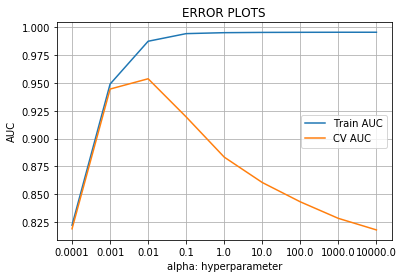

In [51]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l1', C=i,class_weight='balanced')
    clf.fit(train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_tf_idf.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_tf_idf[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_tf_idf.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_tf_idf[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.01 is 0.95

misclassification percentage is 0.10%


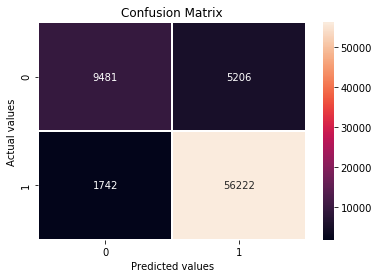



classification report:
              precision    recall  f1-score   support

          0       0.65      0.84      0.73     11223
          1       0.97      0.92      0.94     61428

avg / total       0.92      0.90      0.91     72651



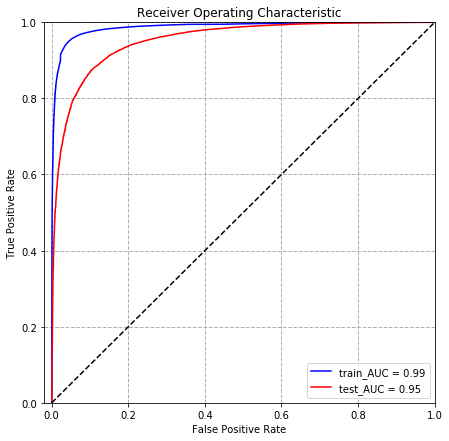

In [58]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.01 #optimum 'C'

clf=LogisticRegression(penalty='l1', C=optimum_c,class_weight='balanced')
clf.fit(train_tf_idf,y_train)


y_pred = []
for i in range(0, test_tf_idf.shape[0], 1000):
    y_pred.extend(clf.predict(test_tf_idf[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_tf_idf.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_tf_idf[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_tf_idf.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_tf_idf[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

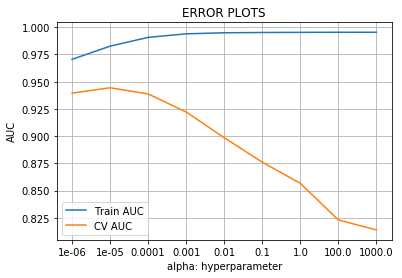

In [81]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-7,10e-6,10e-5,10e-4,10e-3,10e-2,10e-1,10e1,10e2]
for i in c_range:
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_tf_idf.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_tf_idf[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_tf_idf.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_tf_idf[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-7,10e-6,10e-5,10e-4,10e-3,10e-2,10e-1,10e1,10e2))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




genearalisation roc_auc on best alpha-value at optimum_c = 1e-05 is 0.94

misclassification percentage is 0.10%


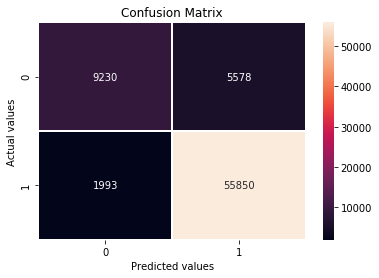



classification report:
              precision    recall  f1-score   support

          0       0.62      0.82      0.71     11223
          1       0.97      0.91      0.94     61428

avg / total       0.91      0.90      0.90     72651



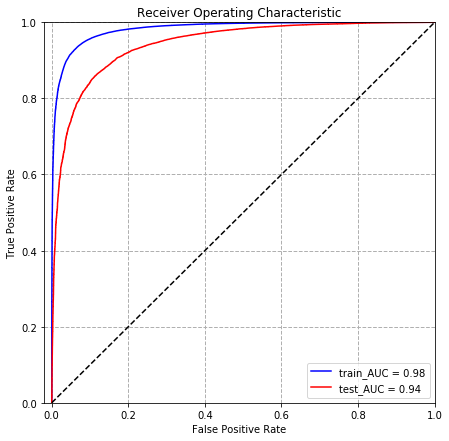

In [85]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.00001 #optimum 'C'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_tf_idf,y_train)


y_pred = []
for i in range(0, test_tf_idf.shape[0], 1000):
    y_pred.extend(clf.predict(test_tf_idf[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_tf_idf.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_tf_idf[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_tf_idf.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_tf_idf[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.00001 #optimum 'C'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_tf_idf,y_train)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
feature_name=tf_idf.get_feature_names() #using count_vectoriser to get features names
coef=clf.coef_ # storing weights of trained model

feat_names=pd.Series(feature_name) #creating pandas series of fearures names

In [89]:
pos_index=np.argsort(coef)[0][-11:-1] #getting index of weights belong to poitive class

#top 10 positive features
pd.DataFrame({'positive features':feat_names[pos_index],"weights":coef[0][pos_index][::-1]})

,positive features,weights
52848,nice,0.068240
36836,highly,0.067292
27089,excellent,0.057845
28439,favorite,0.057679
46321,loves,0.049053
58437,perfect,0.045686
20754,delicious,0.043181
33533,good,0.042787
46287,love,0.041087
7482,best,0.040883


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [90]:
neg_index=np.argsort(coef)[0][:10] #getting index of weights belong to poitive class

#top 10 negative features
pd.DataFrame({'negative features':feat_names[neg_index],"weights":coef[0][neg_index]})

,negative features,weights
53444,not,-0.096251
22377,disappointed,-0.068515
88439,worst,-0.055764
78979,terrible,-0.051268
5533,awful,-0.049462
37571,horrible,-0.047230
5791,bad,-0.046998
86451,waste,-0.046490
22386,disappointing,-0.046039
50646,money,-0.043491


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

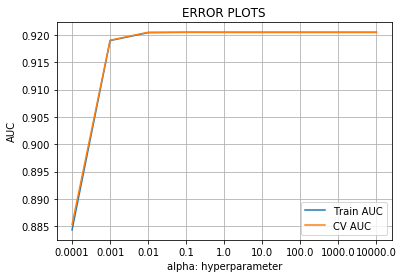

In [82]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l1', C=i,class_weight='balanced')
    clf.fit(train_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_w2v.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_w2v[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_w2v.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_w2v[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.01 is 0.92

misclassification percentage is 0.17%


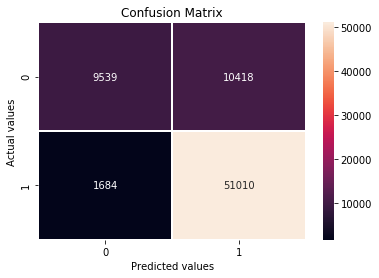



classification report:
              precision    recall  f1-score   support

          0       0.48      0.85      0.61     11223
          1       0.97      0.83      0.89     61428

avg / total       0.89      0.83      0.85     72651



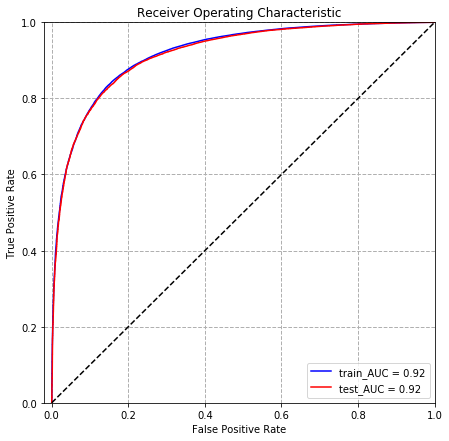

In [91]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.01 #optimum 'C'

clf=LogisticRegression(penalty='l1', C=optimum_c,class_weight='balanced')
clf.fit(train_w2v,y_train)


y_pred = []
for i in range(0, test_w2v.shape[0], 1000):
    y_pred.extend(clf.predict(test_w2v[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_w2v.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_w2v[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_w2v.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_w2v[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

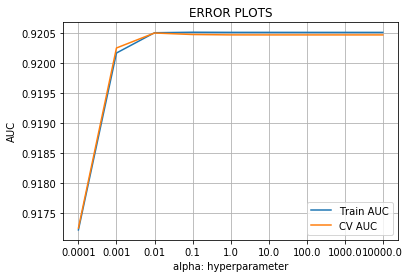

In [83]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(train_w2v, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_w2v.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_w2v[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_w2v.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_w2v[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.01 is 0.92

misclassification percentage is 0.17%


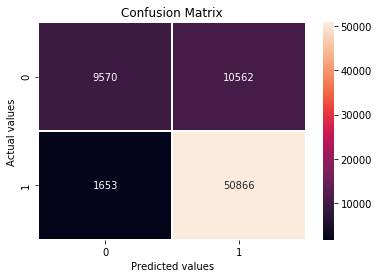



classification report:
              precision    recall  f1-score   support

          0       0.48      0.85      0.61     11223
          1       0.97      0.83      0.89     61428

avg / total       0.89      0.83      0.85     72651



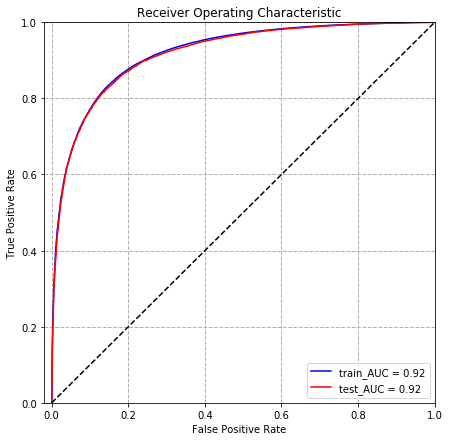

In [92]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.01 #optimum 'C'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_w2v,y_train)


y_pred = []
for i in range(0, test_w2v.shape[0], 1000):
    y_pred.extend(clf.predict(test_w2v[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_w2v.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_w2v[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test,y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_w2v.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_w2v[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test, y_pred_proba)

roc_auc_train = roc_auc_score(y_train,y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test,y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>
#### Note
I am using only 60000 for traning 20000 for cv and 20000 for testing in TFIDF W2V because of computational strain.

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

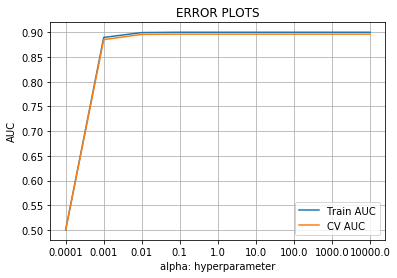

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l1', C=i,class_weight='balanced')
    clf.fit(train_tf_idf_w2v, y_train[:60000])
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_tf_idf_w2v.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_tf_idf_w2v[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_tf_idf_w2v.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_tf_idf_w2v[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train[:60000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[:20000], y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.01 is 0.89

misclassification percentage is 0.19%


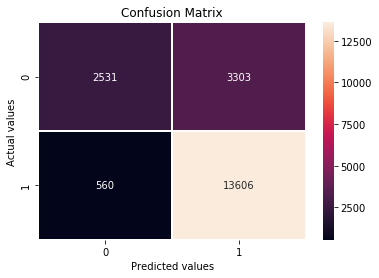



classification report:
              precision    recall  f1-score   support

          0       0.43      0.82      0.57      3091
          1       0.96      0.80      0.88     16909

avg / total       0.88      0.81      0.83     20000



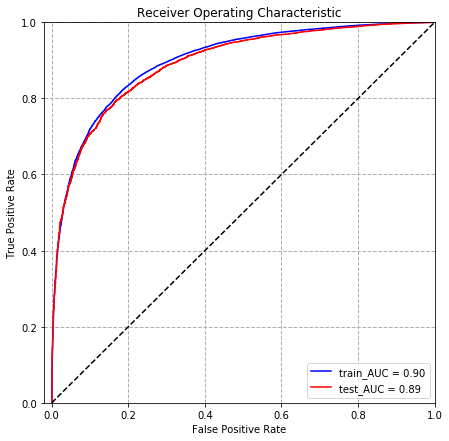

In [6]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.01 #optimum 'C'

clf=LogisticRegression(penalty='l1', C=optimum_c,class_weight='balanced')
clf.fit(train_tf_idf_w2v,y_train[:60000])


y_pred = []
for i in range(0, test_tf_idf_w2v.shape[0], 1000):
    y_pred.extend(clf.predict(test_tf_idf_w2v[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_tf_idf_w2v.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_tf_idf_w2v[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test[:20000],y_pred)
roc_auc=roc_auc_score(y_test[:20000],y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test[:20000]),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test[:20000],y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_tf_idf_w2v.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_tf_idf_w2v[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train[:60000], y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test[:20000], y_pred_proba)

roc_auc_train = roc_auc_score(y_train[:60000],y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test[:20000],y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

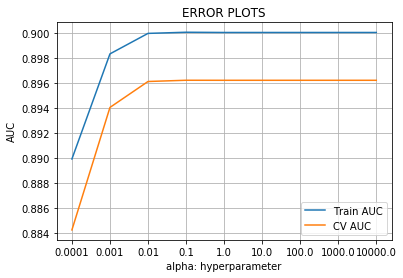

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(train_tf_idf_w2v, y_train[:60000])
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    
    #predicting on train and cv using blocks
    y_train_pred = []
    for i in range(0, train_tf_idf_w2v.shape[0], 1000):
        y_train_pred.extend(clf.predict_proba(train_tf_idf_w2v[i:i+1000])[:,1]) 

    y_cv_pred = []
    for i in range(0, cv_tf_idf_w2v.shape[0], 1000):
        y_cv_pred.extend(clf.predict_proba(cv_tf_idf_w2v[i:i+1000])[:,1]) 


    train_auc.append(roc_auc_score(y_train[:60000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[:20000], y_cv_pred))

    
plt.plot(np.arange(1,10,1), train_auc, label='Train AUC')
plt.plot(np.arange(1,10,1), cv_auc, label='CV AUC')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



genearalisation roc_auc on best alpha-value at optimum_c = 0.01 is 0.89

misclassification percentage is 0.19%


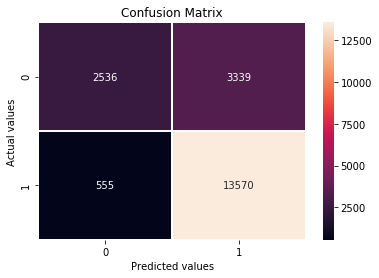



classification report:
              precision    recall  f1-score   support

          0       0.43      0.82      0.57      3091
          1       0.96      0.80      0.87     16909

avg / total       0.88      0.81      0.83     20000



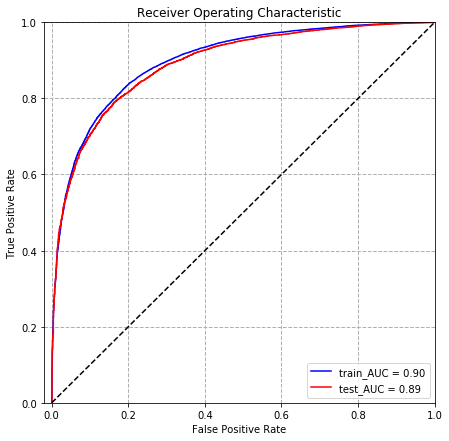

In [7]:
# Test dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#using optimum_k to find generalistion ROC AUC accuracy
optimum_c=0.01 #optimum 'C'

clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_tf_idf_w2v,y_train[:60000])


y_pred = []
for i in range(0, test_tf_idf_w2v.shape[0], 1000):
    y_pred.extend(clf.predict(test_tf_idf_w2v[i:i+1000]))
    
y_pred_proba = []
for i in range(0,test_tf_idf_w2v.shape[0], 1000):
    y_pred_proba.extend(clf.predict_proba(test_tf_idf_w2v[i:i+1000])[:,1])    


accuracy=accuracy_score(y_test[:20000],y_pred)
roc_auc=roc_auc_score(y_test[:20000],y_pred_proba)
print(f'\ngenearalisation roc_auc on best alpha-value at optimum_c = {optimum_c} is {roc_auc:.2f}')
print(f'\nmisclassification percentage is {(1-accuracy):.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_test[:20000]),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
print("\n\nclassification report:\n",classification_report(y_test[:20000],y_pred)) 


# ROC Curve (reference:stack overflow with little modification)   

y_train_pred_proba = []
for i in range(0, train_tf_idf_w2v.shape[0], 1000):
    y_train_pred_proba.extend(clf.predict_proba(train_tf_idf_w2v[i:i+1000])[:,1])


train_fpr, train_tpr, train_threshold =roc_curve(y_train[:60000], y_train_pred_proba)
test_fpr, test_tpr, test_threshold =roc_curve(y_test[:20000], y_pred_proba)

roc_auc_train = roc_auc_score(y_train[:60000],y_train_pred_proba)
roc_auc_test = roc_auc_score(y_test[:20000],y_pred_proba)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'train_AUC = %0.2f' % roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label = 'test_AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(linestyle='--', linewidth=1)
plt.show()



# [6] Conclusions

In [23]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["text featurization", "optimum_hyperparameter:C", "generalization ROC AUC(%age) ", "regularizer",]

x.add_row(["BOW", 0.1,95, "l1"])
x.add_row(["BOW", 0.1,95, "l2"])

x.add_row(["TF-IDF", 0.01,95, "l1"])
x.add_row(["TF-IDF", 0.00001,94, "l2"])

x.add_row(["  W2V", 0.01,92, "l1"])
x.add_row(["  W2V", 0.01,92, "l2"])

x.add_row([" TF-IDF W2V", 0.01,89, "l1"])
x.add_row([" TF-IDF W2V", 0.01,89, "l2"])


print(x)

+--------------------+--------------------------+-------------------------------+-------------+
| text featurization | optimum_hyperparameter:C | generalization ROC AUC(%age)  | regularizer |
+--------------------+--------------------------+-------------------------------+-------------+
|        BOW         |           0.1            |               95              |      l1     |
|        BOW         |           0.1            |               95              |      l2     |
|       TF-IDF       |           0.01           |               95              |      l1     |
|       TF-IDF       |          1e-05           |               94              |      l2     |
|         W2V        |           0.01           |               92              |      l1     |
|         W2V        |           0.01           |               92              |      l2     |
|     TF-IDF W2V     |           0.01           |               89              |      l1     |
|     TF-IDF W2V     |           0.01   

#### Observation
When using 'l1' regurarizer it increases sparsity with increase of hyperparameter value 'C'

Before using Feature Importance we need to make sure if feature is not multicollinear. To check multicollinearity we are using perturbation test.

Feature Importance of Logistic regression is slightly better than naive bayes

Best generaliation ROC AUC is 95% on BOW using L1 regularizer